Below is the code for a kaggle competition that is ongoing 

In [90]:
'''Import the packages needed to run'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [91]:
'''Pull all the data from the .csv files into dataframes'''
supplement_clinical_data=pd.read_csv('supplemental_clinical_data.csv')
train_clinical_data=pd.read_csv('train_clinical_data.csv')
train_peptides=pd.read_csv('train_peptides.csv')
train_proteins=pd.read_csv('train_proteins.csv')

In [92]:
supplement_clinical_data=pd.DataFrame(supplement_clinical_data)
train_clinical_data=pd.DataFrame(train_clinical_data)
train_peptides=pd.DataFrame(train_peptides)
train_proteins=pd.DataFrame(train_proteins)

EXPLORATORY DATA ANALYSIS

Below is the length of each of the datasets for the competition:

In [4]:
print("The length of the train_clinical_data is: ",len(train_clinical_data))
print("The length of the train_peptides is: ",len(train_peptides))
print("The length of the train_proteins is: ",len(train_proteins))
print("The length of the supplement_clinical_data is: ",len(supplement_clinical_data))

The length of the train_clinical_data is:  2615
The length of the train_peptides is:  981834
The length of the train_proteins is:  232741
The length of the supplement_clinical_data is:  2223


Info of each of the datasets that are being extracted and installed into a .csv file in the same directory:

In [5]:
'''Since there are multiple datasets its best to view them in a single csv file which you can later use on Excel spreadsheet or
RStudio for statistical analysis'''

# define list of file paths
dataframes = [train_clinical_data,train_peptides,train_proteins,supplement_clinical_data]

df_info = pd.DataFrame(columns=['File', 'Shape', 'Columns', 'Data types', 'Summary statistics'])


# loop through each file path
for df in dataframes:

    file_name = df.index.name if df.index.name is not None else 'Unnamed index'

    # read in file as a DataFrame    
    # get basic information about the DataFrame
    print('File: ', dataframes)
    print('Shape: ', df.shape)
    print('Columns: ', df.columns)
    print('Data types:\n', df.dtypes)
    print('Summary statistics:\n', df.describe())
    print('\n')


    # get basic information about the DataFrame
    df_shape = pd.DataFrame({'File': file_name, 'Shape': [str(df.shape)]})
    df_cols = pd.DataFrame({'File': file_name, 'Columns': [str(df.columns.tolist())]})
    df_dtypes = pd.DataFrame({'File': file_name, 'Data types': [str(df.dtypes)]})
    df_summary = df.describe().reset_index().rename(columns={'index': 'Summary statistics'})
    df_summary['File'] = file_name
    
    # append the information to the empty DataFrame
    df_info = df_info.append(df_shape)
    df_info = df_info.append(df_cols)
    df_info = df_info.append(df_dtypes)
    df_info = df_info.append(df_summary)

# write the information to a CSV file
df_info.to_csv('data_info.csv', index=False)


File:  [      visit_id  patient_id  visit_month  updrs_1  updrs_2  updrs_3  updrs_4  \
0         55_0          55            0     10.0      6.0     15.0      NaN   
1         55_3          55            3     10.0      7.0     25.0      NaN   
2         55_6          55            6      8.0     10.0     34.0      NaN   
3         55_9          55            9      8.0      9.0     30.0      0.0   
4        55_12          55           12     10.0     10.0     41.0      0.0   
...        ...         ...          ...      ...      ...      ...      ...   
2610  65043_48       65043           48      7.0      6.0     13.0      0.0   
2611  65043_54       65043           54      4.0      8.0     11.0      1.0   
2612  65043_60       65043           60      6.0      6.0     16.0      1.0   
2613  65043_72       65043           72      3.0      9.0     14.0      1.0   
2614  65043_84       65043           84      7.0      9.0     20.0      3.0   

     upd23b_clinical_state_on_medication  


Lets begin with the smaller dataset in this case the supplement_clinical_data dataset:

train_clinical_data.csv

visit_id - ID code for the visit.

visit_month - The month of the visit, relative to the first visit by the patient.

patient_id - An ID code for the patient.

updrs_[1-4] - The patient's score for part N of the Unified Parkinson's Disease Rating Scale. Higher numbers indicate more severe symptoms. Each 
sub-section covers a distinct category of symptoms, such as mood and behavior for Part 1 and motor functions for Part 3.


upd23b_clinical_state_on_medication - Whether or not the patient was taking medication such as Levodopa during the UPDRS assessment. Expected to mainly affect the scores for Part 3 (motor function). These medications wear off fairly quickly (on the order of one day) so it's common for patients to take the motor function exam twice in a single month, both with and without medication.



supplemental_clinical_data.csv Clinical records without any associated CSF samples. This data is intended to provide additional context about the typical progression of Parkinsons. Uses the same columns as train_clinical_data.csv.


Since train_clinical_data & supplement_clinical_data have the same columns lets check the information on them:

In [9]:
print('train_clinical_data Information on columns:\n',train_clinical_data.info())
print('supplement_clinical_data Information on columns:\n',supplement_clinical_data.info())
print('train_peptides Information on columns:\n',train_peptides.info())
print('train_proteins Information on columns:\n',train_proteins.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             2615 non-null   object 
 1   patient_id                           2615 non-null   int64  
 2   visit_month                          2615 non-null   int64  
 3   updrs_1                              2614 non-null   float64
 4   updrs_2                              2613 non-null   float64
 5   updrs_3                              2590 non-null   float64
 6   updrs_4                              1577 non-null   float64
 7   upd23b_clinical_state_on_medication  1288 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 163.6+ KB
train_clinical_data Information on columns:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2223 entries, 0 to 2222
Data columns (total 8 columns):
 #   Column   

Since these two dataframes are identical in terms of col names lets combine them into a single dataframe, however the supplement_clinical_dataframe contains the clincial data relative to a given patient with respect to a particular medication without the CSF values while the train_clinical_data contains the CSF values.

Currently the CSF values are an important factor in understanding the progression PD of the patient, CSF is the Cerebral Spinal Fluid.



In [10]:
all_trained_clinical_data=pd.concat([train_clinical_data,supplement_clinical_data]).reset_index(drop=True)
all_trained_clinical_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [17]:
# The following is the length of the all_trained_clinical_data
print('The length of the all_trained_clinical_data is:', len(all_trained_clinical_data))

# The following is the number unique number or total number of patients removing the duplicates
print("The number of unique patients is: {:,d}".format(all_trained_clinical_data['patient_id'].nunique()))


The length of the all_trained_clinical_data is: 4838
The number of unique patients is: 1,019


In [20]:
'''Null values are being visualized below'''

# This extracts the null numbers per row from the dataframe and puts it in a new column
train_clinical_data['nullCount']=train_clinical_data.isnull().sum(axis=1)

# Now lets look at the null values by grouping them 
nullCount_train_clinical_data = train_clinical_data.groupby('nullCount')['visit_id'].count().to_dict()



In [21]:
nullCount_train_clinical_data 

{0: 1259, 1: 331, 2: 1014, 3: 10, 4: 1}

In [23]:
null_train_clinical_data = {"{} Null Value(s)".format(k) : v for k, v in nullCount_train_clinical_data.items()} 
print(null_train_clinical_data)

{'0 Null Value(s)': 1259, '1 Null Value(s)': 331, '2 Null Value(s)': 1014, '3 Null Value(s)': 10, '4 Null Value(s)': 1}


In [148]:
'''Lets create a null value pipeline function to visualize the data set w.r.t to the visit_id for 
all the dataframes'''

def null_count_visuallisation(df):

    # # Create a unique name for each dataframe in the data
    # df_name='nullCount_'+df.name+'_by_visit_id'

    # create a DataFrame and assign it to a variable with the same name
    globals()['df'] = df

    # get the name of the DataFrame
    df_name=([var for var in globals() if globals()[var] is df][0])

    print('The name of the DataFrame is {}'.format(df_name))



    # This extracts the null numbers per row from the dataframe and puts it in a new column
    df['nullCount']=df.isnull().sum(axis=1)

    # Now lets look at the null values by grouping them 
    null_count = df.groupby('nullCount')['visit_id'].count().to_dict()
    print('The null count for {} is {}'.format(df_name, null_count))


    # Now let's make the structure of the plots 
    # This would be a single row and column plot 
    fig,axs=plt.subplots(figsize=(15,15))
    
    # create the pie chart 
    _=axs.pie(
        x=list(null_count.values()),
        autopct=lambda x: "{:,.0f}={:.2f}%".format(x*sum(null_count)/100,x),
        explode=[0.01]* len(null_count.keys()),
        labels=null_count.keys(),
        colors=sns.color_palette('Set2')[0:len(null_count.keys())],
        textprops={'fontsize': 20}

    ) 
    print('This is the pie chart')

    axs.set_title('Null Count of {}'.format(null_count),color='White',fontsize=20)        
    # axs=axs.flatten()

    # Add a legend 
    axs.legend(title='Features',loc='center left',bbox_to_anchor=(1,0,0.5,1))

    axs.axis('equal')
    axs.set_ylabel('')

    plt.show()

    print('End of pie chart of {}'.format(df_name))
    

    nulllabels_col = [df[(df["nullCount"] == x)].isnull().sum().index[:-1] for x in range(1, 6)]
    nullcount_col = [df[(df["nullCount"] == x)].isnull().sum().values[:-1] for x in range(1, 6)] 
    # create a figure and axis

    # set the width of each bar
    bar_width = 0.1

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(20, 20))

    # set the x-axis ticks and labels
    x_ticks = np.arange(len(nulllabels_col[0]))
    ax.set_xticks(x_ticks + ((len(nulllabels_col) / 2) * bar_width))
    ax.set_xticklabels(nulllabels_col[0])

    # define the colors to use for each bar
    colors = sns.color_palette("Set2", n_colors=5)

    # iterate over the null count values and labels for each column
    for i, (nulllabels_col, nullcount_col) in enumerate(zip(nulllabels_col, nullcount_col), start=1):
        # set the x-position for the current column's bars
        x_pos = x_ticks + (i * bar_width)
        
        # plot the current column's bars
        ax.bar(x_pos, nullcount_col, width=bar_width, color=colors[i-1], label=f"{i} null values")
        
    # set the title and labels for the chart
    ax.set_title("Null Counts by Column and Number of Null Values")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Null Counts")
    ax.legend()

    # show the chart
    plt.show()

    

    return (nulllabels_col,nullcount_col)

The name of the DataFrame is supplement_clinical_data
The null count for supplement_clinical_data is {0: 817, 1: 765, 2: 426, 3: 17, 4: 197, 5: 1}
This is the pie chart


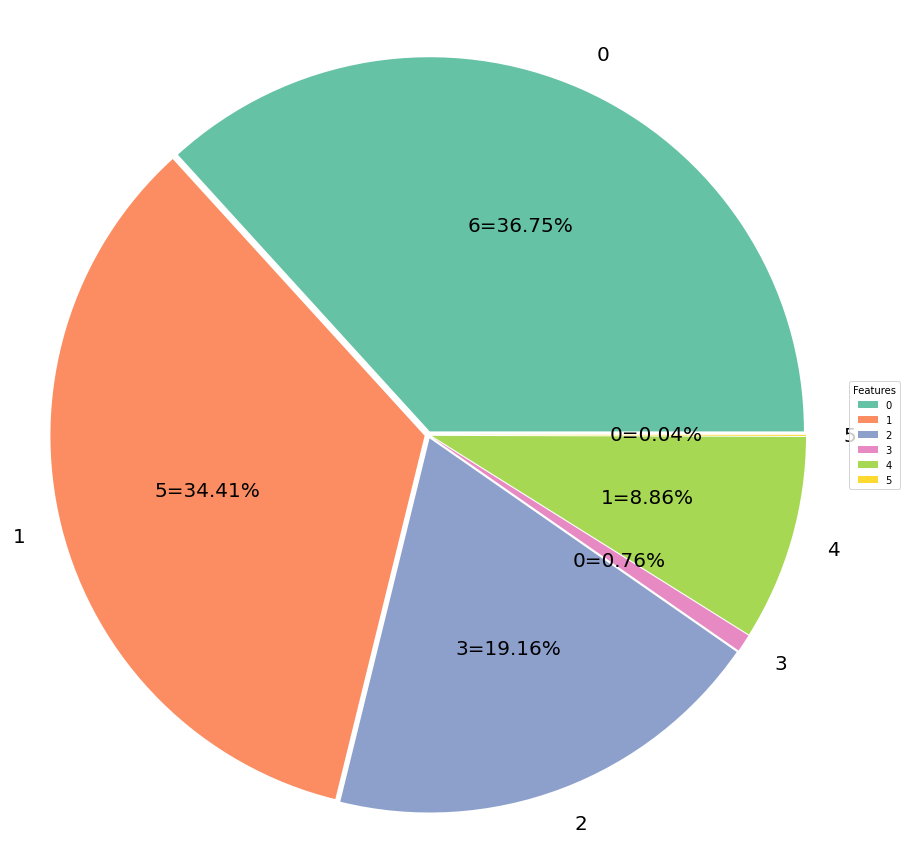

End of pie chart of supplement_clinical_data


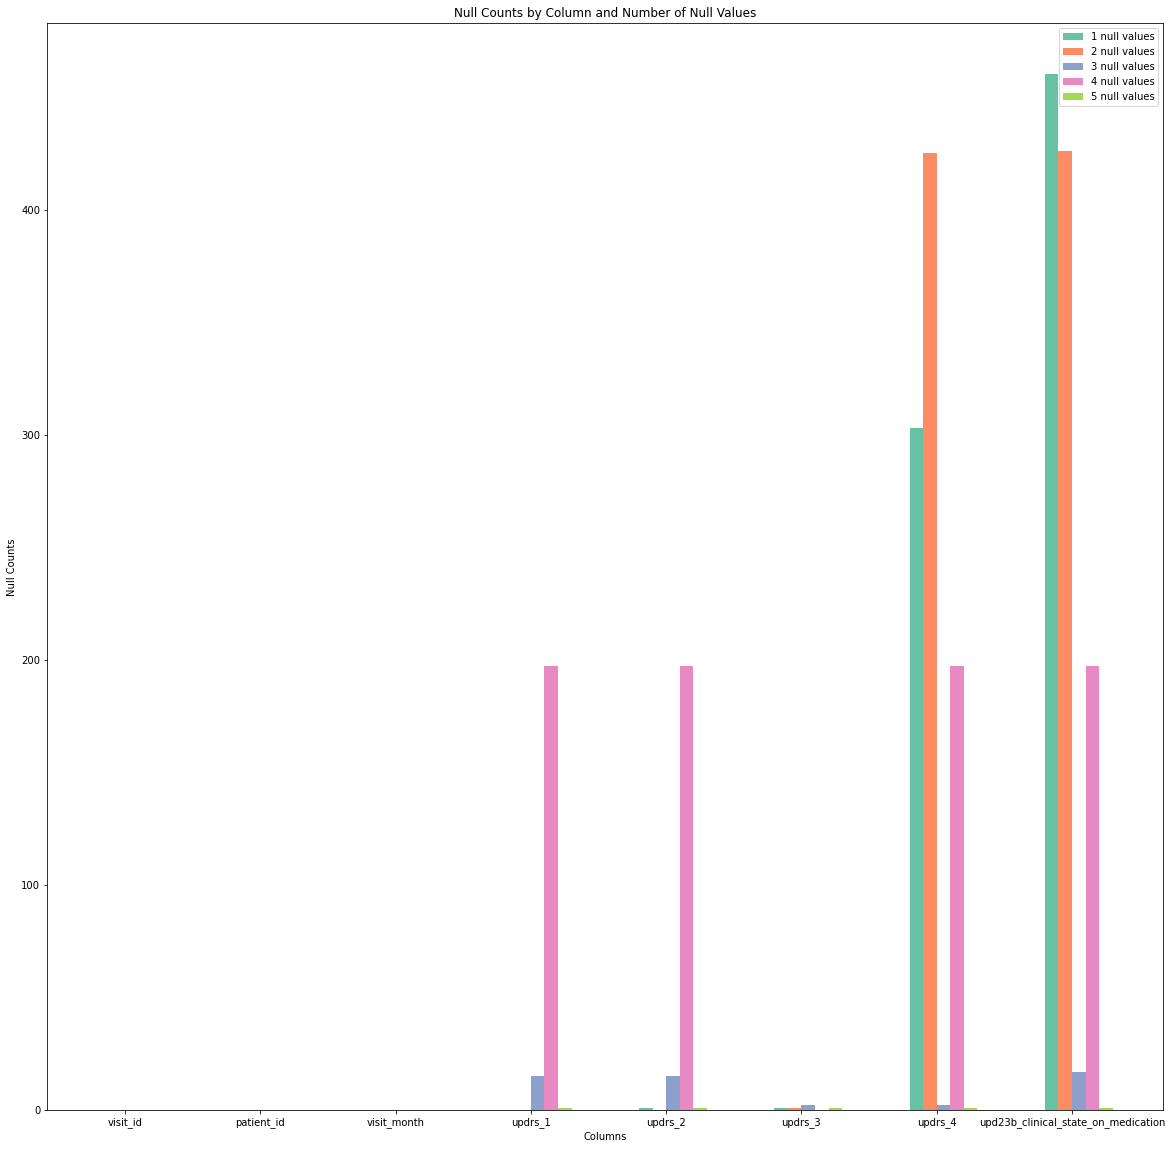

In [149]:
j,k =null_count_visuallisation(supplement_clinical_data)